<a href="https://colab.research.google.com/github/prant1719/BADS7105-CRM/blob/main/HW11_Voice_of_Customers/HW11_Voice_of_Customers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 0 - install and import dependencies**

In [162]:
!pip install pythainlp
!pip install tensorflow_text
!pip install umap-learn

In [163]:
import numpy as np
import pandas as pd
import re

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

import pythainlp
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections


In [164]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' #'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model

model = hub.load(module_url)

In [165]:
df = pd.read_csv("Wongnai Reviews - Small.csv")

In [166]:
df.head()

,Review ID,Review
0,1,เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึงเด...
1,2,Art of Coffee Kasetsart เป็นร้านกาแฟรสชาติเยี่...
2,3,กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...
3,4,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...


In [167]:
df.tail()

,Review ID,Review
295,296,ค่ำนี้คุณเพื่อนอยากส้มตำ หมูเฮาเลยพากันลงมากิน...
296,297,ร้านสะอาดดี ตกแต่งสวยงาม มีที่จอดรถ ราคาเมนูต่...
297,298,เช้าๆ รีบๆ วิ่งมาเข่าห้องเรียนแทบไม่ทันแต่ต้อง...
298,299,ร้านนี้เป็นร้านกาแฟเล็กๆ ข้างๆ ร้านๆ Happy Man...
299,300,ทรูคอฟฟี่สาขาซีคอนอยู่ในศูนย์บริการของทรู ชั้น...


**Step 1 - document embedding and dimension reduction**

In [168]:
#embed sentences using Universal Sentence Encoder (USE)

embed_comments_array = model(df['Review'].values).numpy()
embed_comments_array

array([[ 0.08993827,  0.01941084,  0.03787038, ..., -0.03488849,
         0.06299512,  0.04635989],
       [ 0.00634244,  0.00814594,  0.03071941, ..., -0.01478723,
        -0.03080936, -0.03316405],
       [ 0.0633687 , -0.02027139, -0.05077003, ..., -0.06530775,
        -0.00952999, -0.03439987],
       ...,
       [ 0.08775924,  0.03609736,  0.01263062, ..., -0.03102781,
        -0.03361677,  0.01928871],
       [ 0.05691195,  0.05381691, -0.0399575 , ..., -0.06598807,
        -0.05390478, -0.01037725],
       [ 0.0777048 ,  0.05080631,  0.02680681, ..., -0.0061413 ,
        -0.01313567,  0.02236264]], dtype=float32)

In [169]:
#reduce array dimensions using umap (you can chagne n_components)

reducer = umap.UMAP(random_state=42,n_components=30)
umap_embed_comments_array = reducer.fit_transform(embed_comments_array)

**Step 2 - document clustering using KMeans**

Text(0, 0.5, 'WCSS')

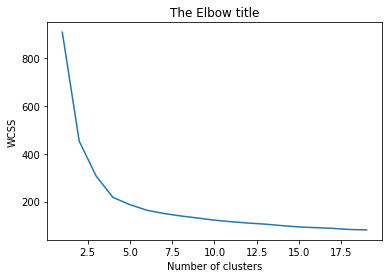

In [170]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 20
for i in range(1, max_k):
  kmeans = KMeans(i)
  kmeans.fit(umap_embed_comments_array)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1, max_k)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [171]:
#run kmeans with no. of clusters you see fit the most

k = 3

kmeans = KMeans(n_clusters = k)
kmeans.fit(umap_embed_comments_array)

df['KMeans ID'] = kmeans.labels_

In [172]:
#merge all reviews of each cluster into one big sentence 

df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(df['Review'][df['KMeans ID'] == i].to_string())
  df_kmeans.loc[len(df_kmeans)] = row

In [173]:
df_kmeans

,KMeans ID,texts
0,0,13 เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่...
1,1,2 กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูห...
2,2,0 เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีว...


In [174]:
#create regex compiler for removal of a character you don't want

special_characters = "/[!@#$%^&*']/g"

specialchar_pattern = re.compile(special_characters)

In [175]:
#create regex compiler for removal of any emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [176]:
#create regex compiler for removal of digit

number_pattern = re.compile("[0-9]")

In [177]:
#create regex compiler for removal of white space

space_pattern = re.compile("\s+")

In [178]:
#create regex compiler for removal of .

dot_pattern = re.compile(r"\.+")

In [179]:
#create regex compiler for removal of \

backslash_pattern = re.compile(r"\\+")

In [205]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization

stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['u','้าน', 'b', 'n', 'nn', 'nn-', '\n','ร้าน','อร่อย','ทาน','รีวิว','คน','กวง','ไหม','หลังอาหาร', 'มื้อ', 'ต่อให้', 'อิ่', 'เช้า', 'บ่าย', 'เย็น','นขา','ตั้งอยู่','เดิน','ลอง','ร้าน', 'กิน', 'ทาน', 'ผม','กก','สวัสดี', 'เก','ก','า','ร้า','เรา','ฉัน','เ','แวะ']
screening_words = stopwords + removed_words

new_words = {"สตารบัก",'shabu','Shabu','ทะเล','อร่อย','แนะนำ','อาหารทะเล','ชานม','cafe','กาแฟ','อร่อย','บาท','สำหรับ','ชื่อ','ทาน','ดี','กิน','อาหาร', 'ปลาร้า','ไม่อร่อย','เรา','หนอ','เสนอ','ใจ'}

words = new_words.union(thai_words())

custom_dictionary_trie = Trie(words)

def tokenize_to_list(sentence):
  merged = []
  words = pythainlp.word_tokenize(str(sentence), engine='multi_cut', custom_dict=custom_dictionary_trie)
  for word in words:
    if word not in screening_words:
      merged.append(word)
  return merged

In [206]:
#clean and tokenize sentences. count the occurences of each word

df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [207]:
#results of tokenization

df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,เคยเป็นไหมกันไหมคะหลังอาหารมื้อใหญ่ต่อให้อิ่เช...,"[ไหมกัน, หลังอาหารมื้อ, อาหารว่าง, คนเรา, หยิบ...","[(ชานม, 11), (ชา, 6), (ไข่มุก, 5), (เครื่องดื่..."
1,1,กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คว...,"[วง, ทะเล, เผา, อาหารทะเล, เค้า, สด, เนื้อ, ปู...","[(ส้มตำ, 7), (อาหาร, 5), (ไทย, 5), (เมนู, 5), ..."
2,2,เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดArt...,"[คนที่, ชอบ, Macchiato, เป็นประจำ, นึง, เด, Ar...","[(ร้านกาแฟ, 15), (ชอบ, 9), (กาแฟ, 8), (้า, 5),..."


In [208]:
#show top keywords of each cluster

top_N_words = 5

for i in range(0, len(df_kmeans)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_N_words]}\n")

#tune a model by remove unwanted characters and words and add more words to a custom dictionary

Cluster ID : 0

Most common words include : [('ชานม', 11), ('ชา', 6), ('ไข่มุก', 5), ('เครื่องดื่ม', 4), ('น้ำ', 3)]

Cluster ID : 1

Most common words include : [('ส้มตำ', 7), ('อาหาร', 5), ('ไทย', 5), ('เมนู', 5), ('เพื่อน', 4)]

Cluster ID : 2

Most common words include : [('ร้านกาแฟ', 15), ('ชอบ', 9), ('กาแฟ', 8), ('้า', 5), ('บรรยากาศ', 5)]



**Step 3 - document clustering using Agglomorative Clustering with euclidean**

In [197]:
#clustering using agglomorative clustering

knn_graph = kneighbors_graph(embed_comments_array,20, include_self=False)
model = AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=5)
model.fit(embed_comments_array)
df['Agglomerative ID'] = model.labels_

In [198]:
#merge all reviews of each cluster into one big sentence 

df_Agglomerative = pd.DataFrame(columns=["Agglomerative ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(str(df['Review'][df['Agglomerative ID'] == i].tolist()))
  df_Agglomerative.loc[len(df_Agglomerative)] = row

In [199]:
df_Agglomerative.tail()

,Agglomerative ID,texts
0,0,['เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึง...
1,1,['วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอ...
2,2,['เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่อให้อ...


In [200]:
#clean and tokenize sentences. count the occurences of each word

df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_Agglomerative['texts_tokenized'] = df_Agglomerative['texts'].apply(lambda x: tokenize_to_list(x))
df_Agglomerative['texts_count'] = df_Agglomerative['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [201]:
#show top keywords of each cluster

top_N_words = 5

for i in range(0, len(df_Agglomerative)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_Agglomerative['texts_count'][i])[:top_N_words]}\n")

Cluster ID : 0

Most common words include : [('กาแฟ', 102), ("','", 47), ('ชอบ', 44), ('ดี', 43), ('สั่ง', 41)]

Cluster ID : 1

Most common words include : [('(', 101), ('เมนู', 100), ('สั่ง', 91), (')', 91), ('รสชาติ', 88)]

Cluster ID : 2

Most common words include : [('ชานม', 62), ('ชา', 42), ('ไข่มุก', 37), ('รสชาติ', 31), (')', 28)]



**Step 4 - result discussion**

 
**Document clustering using KMeans** 

Use k = 3

Top_N_words = 10


1. First group ( Bubble tea lover)
* Dealing with beverage
* Review about  beverage in type of tea and smoothie
2.  Secound group ( Restaurant )
* Dealing with Restaurant 
* Review about location , good taste and branch of restaurant
3.   Last group (Cofee lover)
* Dealing with Cofee lover
* Review about cofee shop , location and atmosphere

**Document clustering using Agglomorative Clustering with euclidean**

1.   First group (Cofee lover)
* Dealing with Cofee lover
* Review about cofee and taste  
2.  Secound group ( Restaurant )
* Dealing with Restaurant 
* Review about good taste and menu
3. Last group ( Bubble tea lover)
* Dealing with Bullble tea 
* Review about  beverage in type of tea 








